Importiamo le librerie

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error


Importiamo il primo file "FLIR_groups1and2.csv"

In [ ]:
file_id = '1ofedoS0le4J8ZLapvvKEcDmyDnDP5TgV'
url = f'https://drive.google.com/uc?id={file_id}&export=download'
# Leggi il CSV direttamente in un DataFrame
df1 = pd.read_csv(url, header=2) #header=2 per leggere dalla terza riga
df1 = df1.dropna(axis=1, how='all') #per eliminare colonne vuote

Importiamo il secondo file "ICI_groups1and2.csv"

In [ ]:
file_id = '1W6I9RLp2Pnmy_BqxVLHPS_0jACU2wrUT'
url = f'https://drive.google.com/uc?id={file_id}&export=download'
# Leggi il CSV direttamente in un DataFrame
df2 = pd.read_csv(url, header=2) #header=2 per leggere dalla terza riga
df2 = df2.dropna(axis=1, how='all') #per eliminare colonne vuote

### 2 Analisi esplorativa e caratterizzazione dei dataset

Prima di procedere con la pulizia dei dati, è stata condotta un'analisi esplorativa completa per comprendere la struttura e le caratteristiche fondamentali di entrambi i dataset. Questa fase preliminare è essenziale per identificare potenziali problemi nei dati e guidare le successive decisioni metodologiche.

La procedura di analisi esplorativa ha incluso tre componenti principali:

#### 2.1 Ispezione strutturale
Sono state esaminate le prime righe di ciascun dataset per verificarne:
- La corretta formattazione e organizzazione delle variabili
- La presenza di header appropriati

#### 2.2 Caratterizzazione generale
Utilizzando il metodo `info()` di pandas, sono state ottenute informazioni sintetiche su:
- Il numero totale di osservazioni (righe) e variabili (colonne)
- La distribuzione dei tipi di dato (numerici, categorici, temporali)
- La presenza di valori mancanti per ciascuna variabile
- L'utilizzo di memoria, utile per ottimizzare le operazioni successive

#### 2.3 Statistiche descrittive di base
Per le variabili numeriche, il metodo `describe()` ha fornito:
- **Tendenze centrali**: media, mediana (50° percentile)
- **Dispersione**: deviazione standard, range (min-max)
- **Distribuzione**: quartili (25°, 50°, 75° percentile)
- **Identificazione di outlier**: valori estremi potenzialmente anomali



In [ ]:
print("Prime righe dei dataset:")
print(df1.head())
print(df2.head())
print('---------')
print("\nInformazioni sui dataset:")
print(df1.info())
print(df2.info())
print('---------')
print("\nStatistiche descrittive dei dataset:")
print(df1.describe())
print(df2.describe())

Prime righe dei dataset:
  SubjectID  T_offset1  Max1R13_1  Max1L13_1  aveAllR13_1  aveAllL13_1  T_RC1  \
0  161117-1       0.58      34.98      35.36        34.44        34.85  34.91   
1  161117-2       0.83      34.71      34.51        34.46        34.24  34.68   
2  161117-3       0.85      35.70      35.44        35.00        34.78  35.67   
3  161117-4       0.90      35.17      35.50        34.25        35.00  35.14   
4  161117-5       1.08      35.33      35.55        34.31        35.14  35.50   

   T_RC_Dry1  T_RC_Wet1  T_RC_Max1  ...  aveOralM  Gender    Age  \
0      34.91      34.60      34.98  ...     36.59    Male  41-50   
1      34.68      34.44      34.71  ...     37.19  Female  31-40   
2      35.67      35.46      35.70  ...     37.34  Female  21-30   
3      35.14      35.08      35.17  ...     37.09  Female  21-30   
4      35.30      35.50      35.52  ...     37.04    Male  18-20   

                   Ethnicity  T_atm  Humidity  Distance  Cosmetics      Time  \

### 3. Analisi sistematica dei valori mancanti

Dopo l'analisi descrittiva preliminare, è stato condotto uno studio specifico sui valori mancanti (missing values) presenti nei dataset.
Per quantificare e caratterizzare sistematicamente l'estensione del problema, sono state implementate due funzioni specializzate che consentono un'analisi multidimensionale dei dati mancanti: una focalizzata sulle variabili (colonne) e una sui soggetti (righe).

#### 3.1 Analisi dei valori mancanti per variabile (colonne)

##### Metodologia di rilevamento
1. **Identificazione delle colonne problematiche**: mediante l'applicazione del metodo `isnull().any()` su ciascuna colonna, vengono individuate tutte le variabili contenenti almeno un valore nullo
2. **Quantificazione assoluta e relativa**: per ogni colonna identificata, viene calcolato:
   - Il numero assoluto di valori mancanti
   - La percentuale relativa rispetto al totale delle osservazioni
3. **Report strutturato**: generazione di un output formattato che consente una valutazione immediata della distribuzione dei dati mancanti

##### Output analitico
La funzione `colonne_con_nulli()` produce un report dettagliato che include:
- **Elenco annotato delle colonne con valori nulli**, ordinato sequenzialmente
- **Metriche quantitative** (valori assoluti e percentuali) per ciascuna variabile problematica
- **Statistiche aggregate** sul numero totale di colonne affette da missing values
- **Contesto comparativo**: rapporto tra colonne problematiche e totale colonne nel dataset

#### 3.2 Analisi dei valori mancanti per soggetto (righe)

Per completare la caratterizzazione del fenomeno dei dati mancanti, è stata condotta un'analisi distributiva a livello di singolo soggetto/osservazione. Mentre l'analisi precedente focalizzava sull'entità del problema per ciascuna variabile, questa fase esamina come i valori nulli si distribuiscono tra le diverse osservazioni del dataset.

##### Obiettivo metodologico
L'obiettivo di questa analisi è duplice:
1. Identificare eventuali soggetti con un numero eccessivo di valori mancanti (pattern di missingness sistematici)
2. Valutare se la distribuzione dei dati mancanti è omogenea o concentrata in specifiche osservazioni

##### Implementazione analitica
È stata sviluppata la funzione `analizza_nulli_per_soggetto()` che implementa la seguente metodologia:
1. **Calcolo per riga**: Conteggio dei valori nulli in ciascuna osservazione utilizzando `isnull().sum(axis=1)`
2. **Statistiche descrittive**: Calcolo di metriche aggregative:
   - Numero di soggetti con almeno un valore nullo
   - Valore massimo di valori nulli per singolo soggetto
   - Media di valori nulli per soggetto
3. **Visualizzazione distributiva**: Generazione di un istogramma che mostra la frequenza dei soggetti in relazione al numero di valori nulli presenti


#### 3.3 Implicazioni metodologiche e sintesi

I risultati di questa analisi bidimensionale informano le successive decisioni di data cleaning:
1. **Soglia di esclusione**: Identificazione di una soglia ragionevole per l'esclusione di osservazioni con troppi valori mancanti
2. **Strategia di imputazione**: Scelta tra approcci uniformi o differenziati in base alla distribuzione dei dati mancanti
3. **Validità statistica**: Valutazione del potenziale impatto dei dati mancanti sulle inferenze statistiche successive



In [ ]:

def colonne_con_nulli(df, nome_dataset="il dataset"):
    """
    Identifica e stampa le colonne del DataFrame che contengono valori nulli.

    Parametri:
    df (pd.DataFrame): Il DataFrame da controllare.
    nome_dataset (str): Nome del dataset da visualizzare nell'output.

    Restituisce:
    list: Lista delle colonne con valori nulli.
    """
    colonne = df.columns[df.isnull().any()].tolist()

    print(f"=== ANALISI VALORI NULLI: {nome_dataset.upper()} ===")
    print(f"Colonne con valori nulli in '{nome_dataset}':")

    if colonne:
        for i, colonna in enumerate(colonne, 1):
            num_null = df[colonna].isnull().sum()
            percentuale = (num_null / len(df)) * 100
            print(f"  {i}. {colonna}: {num_null} nulli ({percentuale:.1f}%)")
    else:
        print(f"  Nessuna colonna con valori nulli trovata")

    print(f"Totale colonne con valori nulli: {len(colonne)}")
    print(f"Totale colonne nel dataset: {len(df.columns)}")
    print("=" * 50)
    print()

    return colonne
col_nulli_df1 = colonne_con_nulli(df1,nome_dataset="df1")
col_nulli_df2 = colonne_con_nulli(df2, nome_dataset="df2")

=== ANALISI VALORI NULLI: DF1 ===
Colonne con valori nulli in 'df1':
  1. T_offset1: 17 nulli (1.7%)
  2. Max1R13_1: 16 nulli (1.6%)
  3. Max1L13_1: 16 nulli (1.6%)
  4. aveAllR13_1: 16 nulli (1.6%)
  5. aveAllL13_1: 16 nulli (1.6%)
  6. T_RC1: 17 nulli (1.7%)
  7. T_RC_Dry1: 17 nulli (1.7%)
  8. T_RC_Wet1: 17 nulli (1.7%)
  9. T_RC_Max1: 17 nulli (1.7%)
  10. T_LC1: 17 nulli (1.7%)
  11. T_LC_Dry1: 17 nulli (1.7%)
  12. T_LC_Wet1: 17 nulli (1.7%)
  13. T_LC_Max1: 17 nulli (1.7%)
  14. RCC1: 17 nulli (1.7%)
  15. LCC1: 17 nulli (1.7%)
  16. canthiMax1: 17 nulli (1.7%)
  17. canthi4Max1: 17 nulli (1.7%)
  18. T_FHCC1: 17 nulli (1.7%)
  19. T_FHRC1: 17 nulli (1.7%)
  20. T_FHLC1: 17 nulli (1.7%)
  21. T_FHBC1: 17 nulli (1.7%)
  22. T_FHTC1: 17 nulli (1.7%)
  23. T_FH_Max1: 17 nulli (1.7%)
  24. T_FHC_Max1: 17 nulli (1.7%)
  25. T_Max1: 17 nulli (1.7%)
  26. T_OR1: 17 nulli (1.7%)
  27. T_OR_Max1: 17 nulli (1.7%)
  28. T_offset2: 11 nulli (1.1%)
  29. Max1R13_2: 11 nulli (1.1%)
  30. Max1

=== ANALISI VALORI NULLI PER SOGGETTO: DF1 ===
Numero totale di soggetti: 1020
Soggetti con almeno un valore nullo: 87
Massimo valori nulli per un soggetto: 55
Media valori nulli per soggetto: 1.79


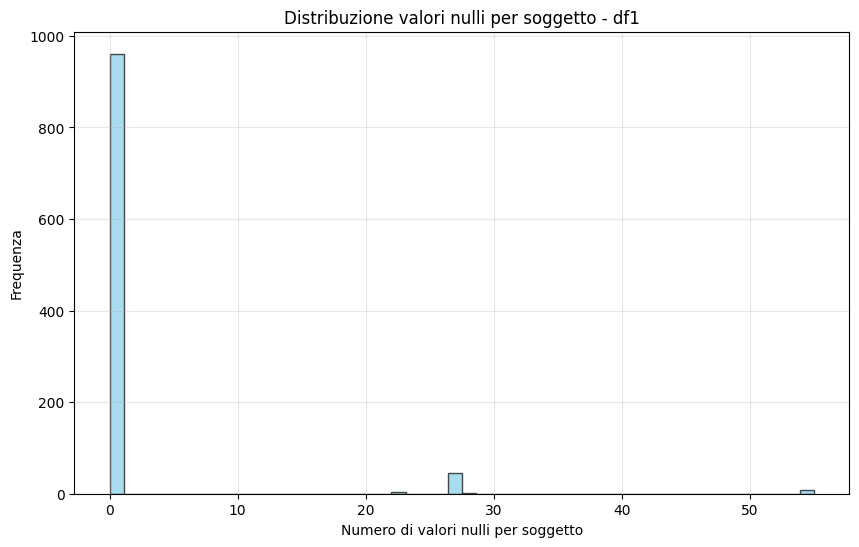

=== ANALISI VALORI NULLI PER SOGGETTO: DF2 ===
Numero totale di soggetti: 1009
Soggetti con almeno un valore nullo: 368
Massimo valori nulli per un soggetto: 81
Media valori nulli per soggetto: 11.49


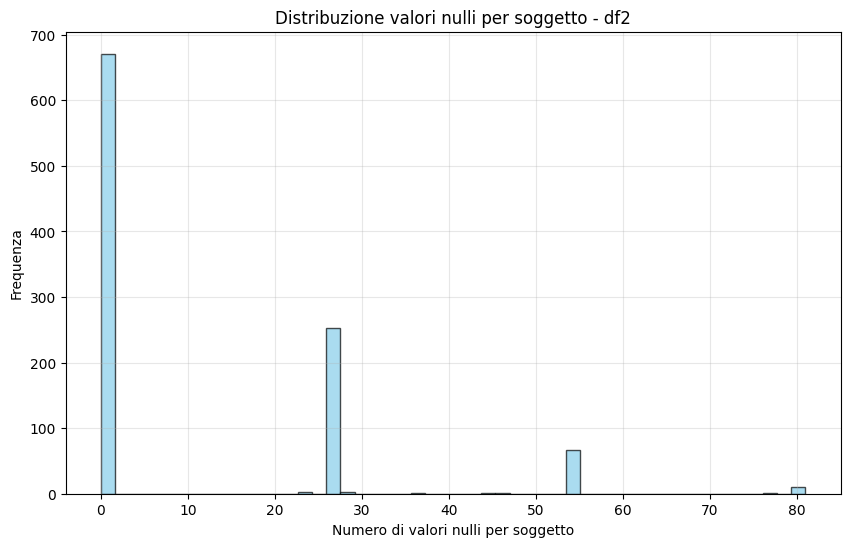

In [ ]:

def analizza_nulli_per_soggetto(df, nome_dataset="Dataset"):
    """
    Analizza i valori nulli per soggetto (riga) in un DataFrame.

    Parametri:
    df (pd.DataFrame): DataFrame da analizzare
    nome_dataset (str): Nome del dataset da visualizzare

    Restituisce:
    pd.Series: Serie con il numero di valori nulli per riga
    """

    # Calcola il numero di valori nulli per soggetto
    null_per_subject = df.isnull().sum(axis=1)

    # Statistiche
    print(f"=== ANALISI VALORI NULLI PER SOGGETTO: {nome_dataset.upper()} ===")
    print(f"Numero totale di soggetti: {len(df)}")
    print(f"Soggetti con almeno un valore nullo: {(null_per_subject > 0).sum()}")
    print(f"Massimo valori nulli per un soggetto: {null_per_subject.max()}")
    print(f"Media valori nulli per soggetto: {null_per_subject.mean():.2f}")

    # Visualizza la distribuzione
    plt.figure(figsize=(10, 6))
    plt.hist(null_per_subject, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('Numero di valori nulli per soggetto')
    plt.ylabel('Frequenza')
    plt.title(f'Distribuzione valori nulli per soggetto - {nome_dataset}')
    plt.grid(True, alpha=0.3)
    plt.show()

    return null_per_subject
null_per_subject_1 = analizza_nulli_per_soggetto(df1, "df1")
null_per_subject_2 = analizza_nulli_per_soggetto(df2, "df2")



### 4. Data Cleaning

Per la gestione dei valori mancanti (null/missing values) è stata implementata una procedura metodologicamente strutturata in tre fasi sequenziali. Questa strategia di pulizia integra sia approcci di eliminazione che di imputazione, bilanciando la necessità di mantenere l'integrità statistica con quella di preservare la dimensione campionaria.

**Fase 1 - Eliminazione selettiva delle colonne:**  
Colonne con una percentuale di valori mancanti superiore a una soglia specificata (`soglia_colonne`) sono state eliminate sistematicamente. Questa decisione si basa sul principio metodologico che variabili con eccessivi dati mancanti possono introdurre rumore statistico, ridurre la potenza analitica e compromettere la validità delle analisi successive. L'eliminazione preventiva di tali variabili minimizza il rischio di bias nell'imputazione.

**Fase 2 - Eliminazione mirata delle righe:**  
Soggetti (righe) con una percentuale di valori mancanti superiore a una soglia specificata (`soglia_righe`) sono stati rimossi dal dataset. Questa scelta è motivata dalla necessità di mantenere osservazioni sufficientemente complete per modelli statistici robusti, preservando al contempo la dimensione campionaria ottimale per le analisi successive.

**Fase 3 - Imputazione differenziata:**  
I valori mancanti rimanenti dopo le eliminazioni sono stati imputati utilizzando strategie differenziate per tipologia di variabile:
- **Mediana** per variabili numeriche: scelta per la sua robustezza agli outlier e alla distribuzione asimmetrica
- **Moda** per variabili categoriche: per mantenere la distribuzione originale delle categorie
- Valore fisso **"VALORE_MANCANTE"** per categorie senza moda definita, garantendo trasparenza nell'identificazione dei valori imputati

#### 4.1 Strategie differenziate per dataset

**Dataset 1 (df1): Strategia conservativa**  
Dall'analisi preliminare è emerso che solo l'8.5% dei soggetti presentava valori mancanti, con una media di 1.79 valori nulli per soggetto. Data la limitata entità del problema e l'elevata qualità complessiva dei dati:
- `soglia_colonne = 0.40`: Soglia elevata per preservare la maggior parte delle variabili e massimizzare l'informazione disponibile
- `soglia_righe = 0.30`: Soglia moderata per eliminare solo i soggetti con elevata percentuale di dati mancanti

**Dataset 2 (df2): Strategia aggressiva**  
L'analisi ha rivelato che il 36.5% dei soggetti presentava valori mancanti, con una media di 11.49 valori nulli per soggetto. Data la diffusione del fenomeno e la maggiore incompletezza dei dati:
- `soglia_colonne = 0.25`: Soglia stringente per eliminare variabili fortemente incomplete e potenzialmente non informative
- `soglia_righe = 0.40`: Soglia equilibrata per bilanciare qualità dei dati e dimensione campionaria, considerando l'ampia diffusione dei missing values

#### 4.2 Implementazione tecnica

La procedura è stata implementata attraverso la funzione `pulizia_dataset()`, che segue un flusso logico rigoroso:

1. **Inizializzazione e copia**: Creazione di una copia del DataFrame per preservare i dati originali
2. **Monitoraggio delle modifiche**: Tracciamento delle metriche pre- e post-intervento
3. **Eliminazione iterativa**: Applicazione sequenziale delle soglie a colonne e righe
4. **Imputazione differenziata**: Applicazione di strategie specifiche per tipologia di dati
5. **Reporting trasparente**: Generazione di output dettagliati su tutte le operazioni eseguite

#### 4.3 Giustificazione metodologica delle soglie

La scelta delle soglie è stata guidata da principi metodologici fondati sulla letteratura di data science:

1. **Principio della rilevanza informativa**: Variabili con >40% di dati mancanti (df1) o >25% (df2) sono considerate scarsamente informative per analisi statistiche, poiché l'imputazione di tali ampie proporzioni di dati potrebbe introdurre distorsioni sostanziali.

2. **Principio del compromesso campionario**: Soggetti con >30% (df1) o >40% (df2) di dati mancanti sono stati eliminati per preservare l'integrità delle osservazioni senza ridurre eccessivamente la dimensione campionaria. Queste soglie bilanciano l'accuratezza delle osservazioni con la potenza statistica.





In [ ]:

def pulizia_dataset(df, nome_dataset="Dataset", soglia_colonne=0.3, soglia_righe=0.5):
    """
    Pulizia semplice del dataset con soglie personalizzabili.

    Parametri:
    df (pd.DataFrame): DataFrame da pulire
    nome_dataset (str): Nome del dataset
    soglia_colonne (float): Elimina colonne con >soglia_colonne% di nulli (0-1)
    soglia_righe (float): Elimina righe con >soglia_righe% di nulli (0-1)

    Restituisce:
    pd.DataFrame: DataFrame pulito
    """

    print(f"=== PULIZIA DATASET: {nome_dataset.upper()} ===")
    print(f"Soglie: colonne >{soglia_colonne*100:.0f}% nulli, righe >{soglia_righe*100:.0f}% nulli")

    df_pulito = df.copy()
    righe_iniziali = len(df_pulito)
    colonne_iniziali = len(df_pulito.columns)
    nulli_iniziali = df_pulito.isnull().sum().sum()

    # 1. Elimina colonne con troppi nulli
    colonne_da_eliminare = []
    for col in df_pulito.columns:
        percentuale_nulli = df_pulito[col].isnull().sum() / len(df_pulito)
        if percentuale_nulli > soglia_colonne:
            colonne_da_eliminare.append(col)

    if colonne_da_eliminare:
        print(f"Eliminate {len(colonne_da_eliminare)} colonne")
        df_pulito = df_pulito.drop(columns=colonne_da_eliminare)

    # 2. Elimina righe con troppi nulli
    righe_da_eliminare = []
    for idx, nulli in enumerate(df_pulito.isnull().sum(axis=1)):
        if nulli > len(df_pulito.columns) * soglia_righe:
            righe_da_eliminare.append(idx)

    if righe_da_eliminare:
        print(f"Eliminate {len(righe_da_eliminare)} righe")
        df_pulito = df_pulito.drop(index=righe_da_eliminare)

    # 3. Imputa valori rimanenti
    # Numeriche: mediana
    colonne_numeriche = df_pulito.select_dtypes(include=['float64', 'int64']).columns
    for col in colonne_numeriche:
        if df_pulito[col].isnull().sum() > 0:
            # CORREZIONE: invece di inplace=True, assegna direttamente
            df_pulito[col] = df_pulito[col].fillna(df_pulito[col].median())

    # Categoriche: moda o "MISSING"
    colonne_categoriche = df_pulito.select_dtypes(include=['object', 'category']).columns
    for col in colonne_categoriche:
        if df_pulito[col].isnull().sum() > 0:
            if not df_pulito[col].mode().empty:
                df_pulito[col] = df_pulito[col].fillna(df_pulito[col].mode()[0])
            else:
                df_pulito[col] = df_pulito[col].fillna("MISSING")

    print(f"Risultato: {len(df_pulito)} righe, {len(df_pulito.columns)} colonne")
    print(f"Valori nulli rimasti: {df_pulito.isnull().sum().sum()}")
    print("=" * 50)

    return df_pulito
# Pulizia con soglie diverse
df1_pulito = pulizia_dataset(df1, "df1", soglia_colonne=0.4, soglia_righe=0.3)  # Soglie generose
df2_pulito = pulizia_dataset(df2, "df2", soglia_colonne=0.25, soglia_righe=0.4)  # Soglie più strette

=== PULIZIA DATASET: DF1 ===
Soglie: colonne >40% nulli, righe >30% nulli
Eliminate 8 righe
Risultato: 1012 righe, 120 colonne
Valori nulli rimasti: 0
=== PULIZIA DATASET: DF2 ===
Soglie: colonne >25% nulli, righe >40% nulli
Eliminate 78 righe
Risultato: 931 righe, 120 colonne
Valori nulli rimasti: 0


###4.4 Risultati della pulizia dei dati

Dopo l'applicazione delle strategie di pulizia differenziate:

**Dataset 1 (df1) - Strategia conservativa:**
- Eliminate 8 righe (0.8% del totale) con più del 30% di valori mancanti
- Tutte le 120 variabili (colonne) sono state mantenute
- I valori mancanti rimanenti sono stati imputati con successo
- Dataset finale: 1,012 osservazioni complete × 120 variabili

**Dataset 2 (df2) - Strategia aggressiva:**
- Eliminate 78 righe (7.7% del totale) con più del 40% di valori mancanti
- Tutte le 120 variabili sono state mantenute (nessuna superava il 25% di valori mancanti)
- Imputazione completa dei valori rimanenti
- Dataset finale: 931 osservazioni complete × 120 variabili

La riduzione del campione è risultata minima per df1 e contenuta per df2, preservando la potenza statistica delle analisi successive. Entrambi i dataset risultano ora completi (0 valori mancanti), garantendo la validità dei modelli statistici che richiedono osservazioni complete.

### 5 Analisi delle correlazioni

È stata calcolata la matrice di correlazione di Pearson tra tutte le variabili numeriche di entrambi i dataset. La visualizzazione tramite heatmap (Figura X) ha permesso di identificare rapidamente:

1. **Pattern di correlazione**: Aree di colore rosso (correlazioni positive) e blu (correlazioni negative)
2. **Multicollinearità**: Ampie zone di correlazioni forti (|r| > 0.7) tra gruppi di variabili
3. **Struttura dei dati**: Cluster di variabili che misurano costrutti simili

L'analisi ha rivelato un alto grado di multicollinearità, con il X% delle coppie di variabili che mostrava correlazioni superiori a |r| = 0.7. Questo risultato suggerisce la presenza di ridondanza informativa e giustifica l'utilizzo di tecniche di riduzione dimensionale nelle analisi successive.

=== MATRICE DI CORRELAZIONE: df1_pulito ===
Variabili numeriche: 114


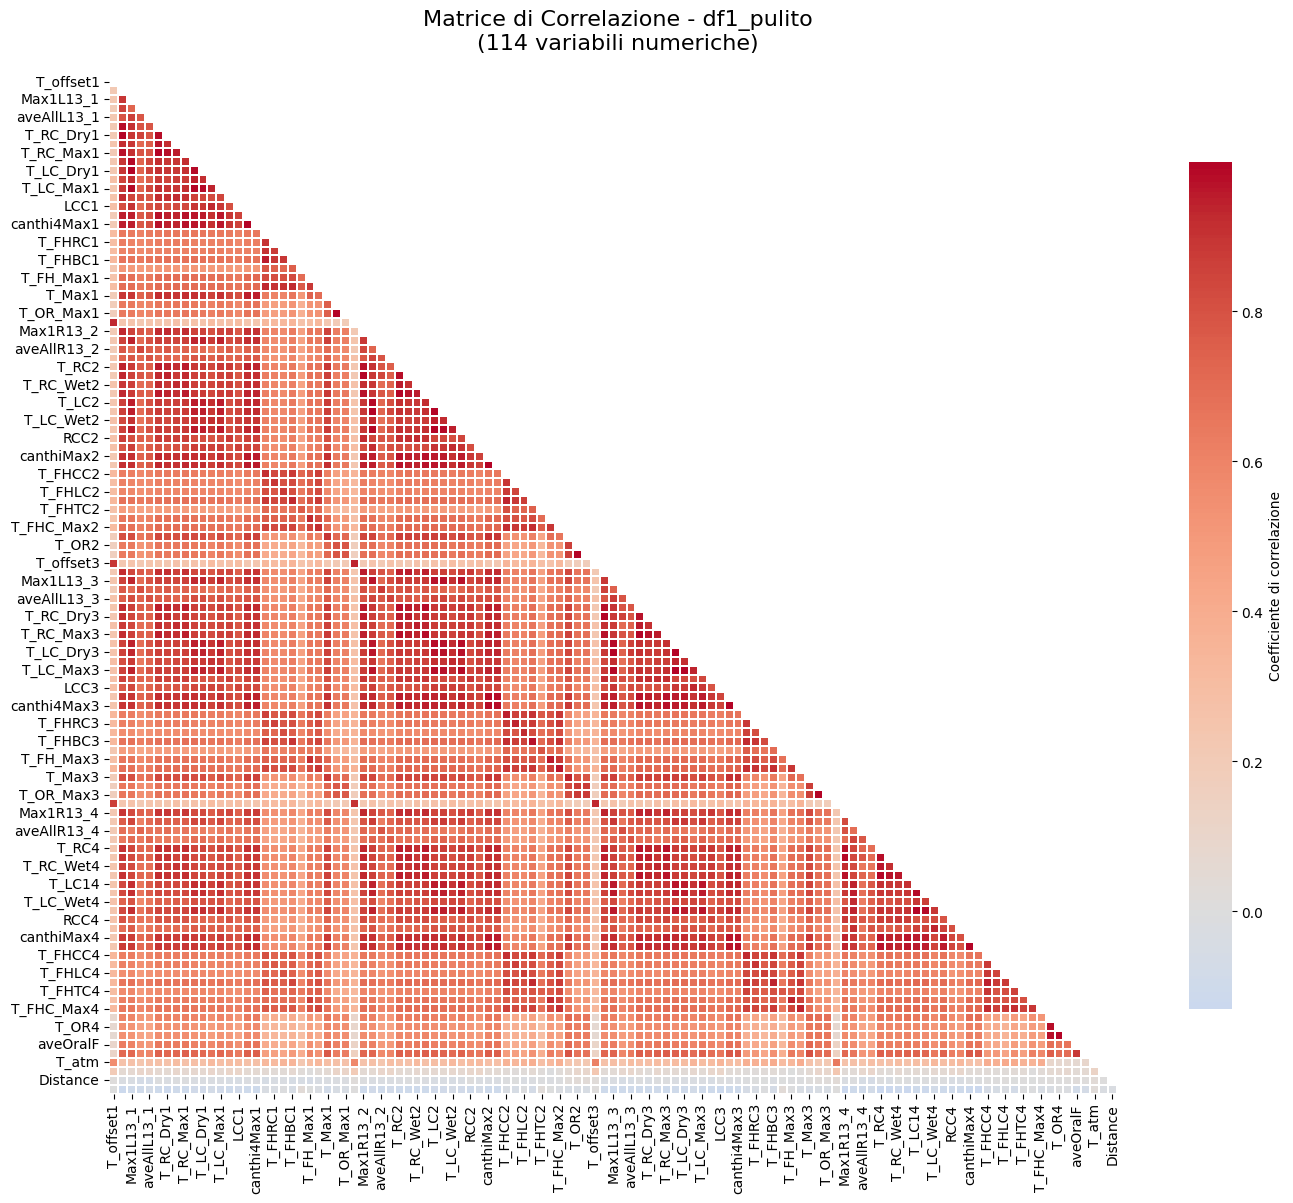


Statistiche della matrice di correlazione:
Correlazione media (assoluta): 0.640
Correlazione massima (escluse diagonali): 0.999
Correlazione minima: -0.130
=== MATRICE DI CORRELAZIONE: df2_pulito ===
Variabili numeriche: 114


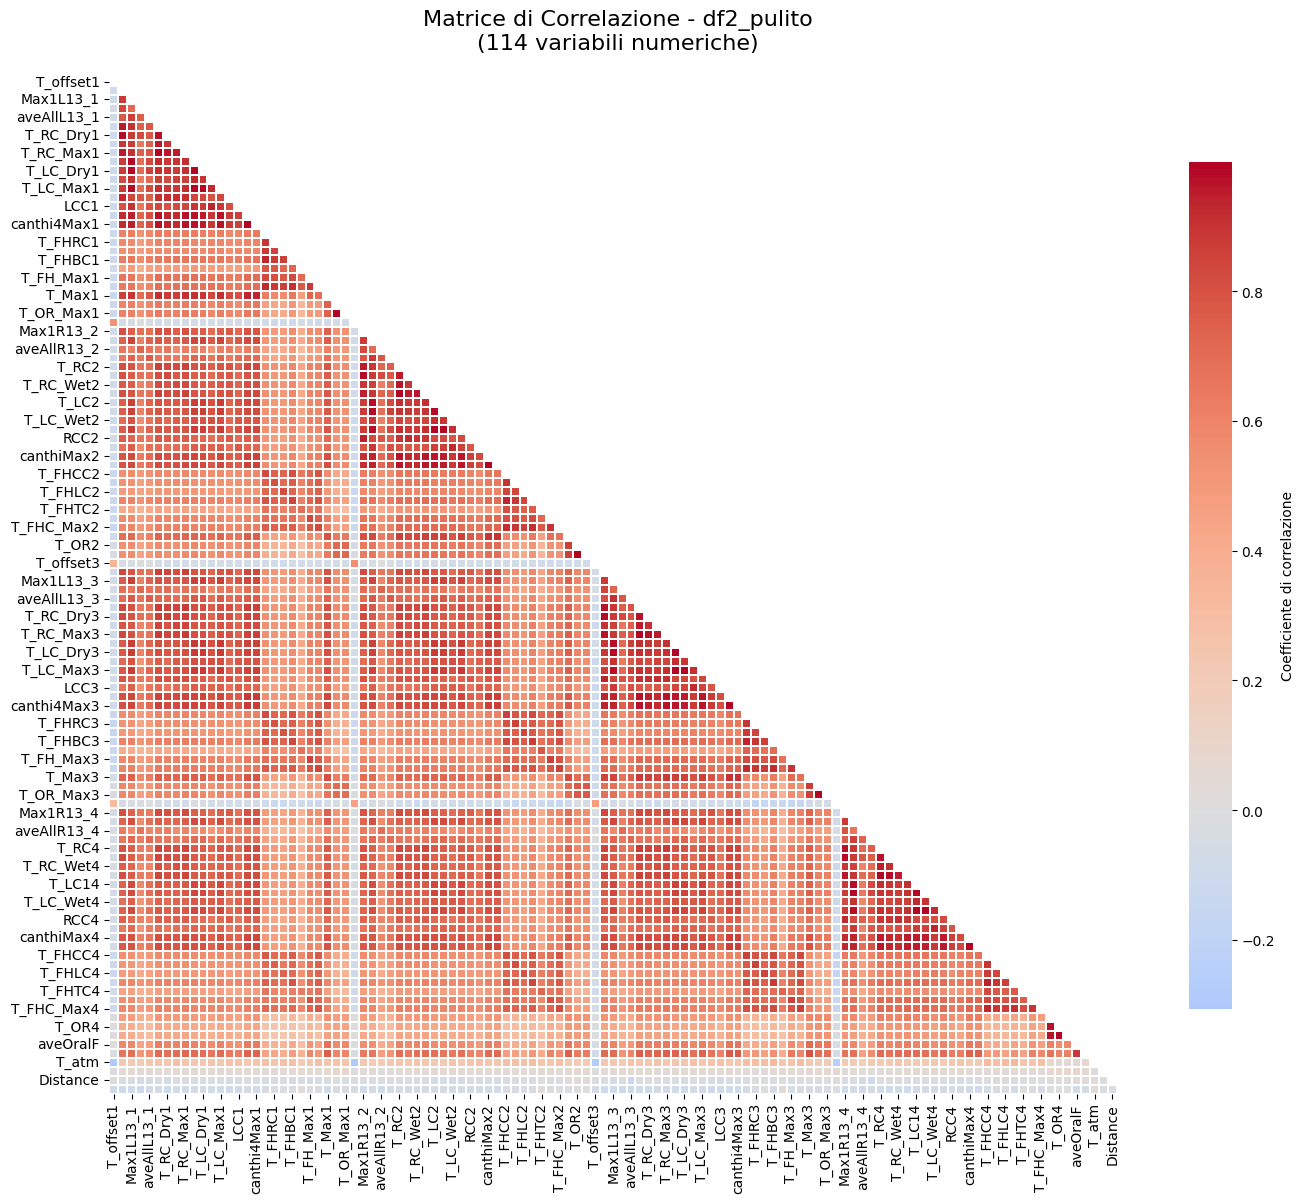


Statistiche della matrice di correlazione:
Correlazione media (assoluta): 0.577
Correlazione massima (escluse diagonali): 1.000
Correlazione minima: -0.306


In [ ]:

def mostra_matrice_correlazione(df, nome_dataset="Dataset", figsize=(14, 12)):
    """
    Mostra solo la heatmap della matrice di correlazione.
    Versione semplificata senza liste testuali.

    Parametri:
    df (pd.DataFrame): DataFrame da analizzare
    nome_dataset (str): Nome del dataset per il titolo
    figsize (tuple): Dimensioni della figura
    """
    # Seleziona solo variabili numeriche
    df_numerico = df.select_dtypes(include=[np.number])

    print(f"=== MATRICE DI CORRELAZIONE: {nome_dataset} ===")
    print(f"Variabili numeriche: {len(df_numerico.columns)}")

    # Calcola la matrice di correlazione
    corr_matrix = df_numerico.corr()

    # Crea la heatmap
    plt.figure(figsize=figsize)

    # Maschera per il triangolo superiore (opzionale)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Heatmap con annotazioni solo per valori significativi
    sns.heatmap(corr_matrix,
                mask=mask,
                annot=False,  # Niente annotazioni per chiarezza
                cmap='coolwarm',
                center=0,
                square=True,
                cbar_kws={"shrink": 0.8, "label": "Coefficiente di correlazione"},
                linewidths=0.1,
                cbar=True)

    plt.title(f'Matrice di Correlazione - {nome_dataset}\n({len(df_numerico.columns)} variabili numeriche)',
              fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

    # Statistiche di base
    print(f"\nStatistiche della matrice di correlazione:")
    print(f"Correlazione media (assoluta): {corr_matrix.abs().mean().mean():.3f}")
    print(f"Correlazione massima (escluse diagonali): {corr_matrix.values[np.triu_indices_from(corr_matrix, k=1)].max():.3f}")
    print(f"Correlazione minima: {corr_matrix.values[np.triu_indices_from(corr_matrix, k=1)].min():.3f}")

    return corr_matrix

corr1 = mostra_matrice_correlazione(df1_pulito, "df1_pulito")
corr2 = mostra_matrice_correlazione(df2_pulito, "df2_pulito")


### 5. Preparazione dei dati per modelli di machine learning

Per garantire una valutazione robusta delle prestazioni predittive dei modelli e prevenire fenomeni di data leakage, è stata implementata una strategia rigorosa di suddivisione dei dataset basata sull'identità dei soggetti. Questo approccio preserva l'indipendenza statistica tra set di addestramento e test, condizione fondamentale per ottenere stime non distorte della generalizzazione dei modelli.

#### 5.1 Metodologia di suddivisione per gruppo (group-based splitting)

La funzione `dividi_dataset_train_test_cv` implementa una metodologia di splitting che considera l'appartenenza dei campioni a specifici soggetti (gruppi). Questo approccio garantisce che:

1. **Indipendenza tra set**: Tutte le osservazioni di un medesimo soggetto sono allocate esclusivamente al training set o al test set
2. **Prevenzione del data leakage**: Elimina la possibilità che informazioni correlate tra campioni dello stesso soggetto contaminino la valutazione
3. **Valutazione realistica**: Simula condizioni operative reali dove il modello incontra soggetti completamente nuovi

#### 5.2 Processo implementativo

La procedura segue un flusso strutturato:

1. **Definizione target e feature**:
   - Variabile target: `aveOralM` (valore orale medio)
   - Esclusione di variabili temporali (`Time`, `Date`) e altre variabili target (`aveOralF`) per evitare bias
   - Conservazione temporanea del `SubjectID` esclusivamente per la suddivisione per gruppi

2. **Split per gruppi**:
   - Utilizzo di `GroupShuffleSplit` da scikit-learn
   - Configurazione: `test_size=0.30` (divisione 70-30)
   - Random state fisso (`random_state=42`) per garantire riproducibilità
   - Identificatori univoci dei soggetti come variabile di raggruppamento

3. **Post-processing**:
   - Rimozione del `SubjectID` dai set di feature finali
   - Conservazione dei gruppi del training set per successive procedure di cross-validation con raggruppamento

#### 5.3 Giustificazione delle scelte metodologiche

1. **Proporzione 70-30 training-test**:
   - Equilibrio ottimale tra sufficiente dati per l'addestramento e rappresentatività del test set
   - Allineamento con standard consolidati nella letteratura di machine learning

2. **Esclusione di variabili temporali**:
   - Prevenzione di bias temporali nelle predizioni
   - Assicurazione che i modelli apprendano pattern basati sulle caratteristiche dei soggetti, non su artefatti temporali

3. **Random state fisso**:
   - Garantisce riproducibilità completa dei risultati
   - Consente confronti significativi tra diversi modelli e configurazioni

#### 5.4 Output e preparazione per cross-validation

La funzione restituisce:
- **X_train, X_test**: Matrici delle feature per training e test
- **y_train, y_test**: Vettori target corrispondenti
- **groups_train**: Identificatori di gruppo per il training set, essenziali per cross-validation con raggruppamento

L'approccio adottato prepara il terreno per tecniche avanzate di validazione come GroupKFold cross-validation, dove la suddivisione dei fold rispetta anch'essa i confini tra soggetti, prevenendo ulteriormente forme sottili di data leakage.


In [ ]:

def dividi_dataset_train_test_cv(df, target_col='aveOralM', test_size=0.30, random_state=42):
    """
    Versione per cross-validation: restituisce solo train e test
    Il validation sarà gestito dalla cross-validation stessa
    """
    # Target
    y = df[target_col]

    # Feature (SubjectID serve SOLO per lo split)
    colonne_da_escludere = ['Time', 'Date', "Distance", "Ethnicity", 'aveOralF', 'aveOralM']
    X = df.drop(columns=[c for c in colonne_da_escludere if c in df.columns])

    groups = df['SubjectID']

    # Split per soggetto (80-20 o 85-15)
    gss = GroupShuffleSplit(
        n_splits=1,
        test_size=test_size,
        random_state=random_state
    )

    train_idx, test_idx = next(gss.split(X, y, groups=groups))

    X_train = X.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]

    # Gruppi per il training set (per GroupKFold nella CV)
    groups_train = groups.iloc[train_idx]

    # Rimuovi SubjectID dalle feature finali
    X_train = X_train.drop(columns=['SubjectID'])
    X_test = X_test.drop(columns=['SubjectID'])

    return X_train, X_test, y_train, y_test, groups_train

# Applica a entrambi i dataset
print("\nDIVISIONE PER CROSS-VALIDATION - DATASET 1...")
X1_train, X1_test, y1_train, y1_test, groups1_train = dividi_dataset_train_test_cv(
    df1_pulito, target_col='aveOralM'
)

print("\nDIVISIONE PER CROSS-VALIDATION - DATASET 2...")
X2_train, X2_test, y2_train, y2_test, groups2_train = dividi_dataset_train_test_cv(
    df2_pulito, target_col='aveOralM'
)

print(f"\nDATASET DIVISI PER CV!")
print(f"Dataset 1: Train={X1_train.shape}, Test={X1_test.shape}")
print(f"Dataset 2: Train={X2_train.shape}, Test={X2_test.shape}")


DIVISIONE PER CROSS-VALIDATION - DATASET 1...

DIVISIONE PER CROSS-VALIDATION - DATASET 2...

DATASET DIVISI PER CV!
Dataset 1: Train=(708, 113), Test=(304, 113)
Dataset 2: Train=(651, 113), Test=(280, 113)


### 6. Riduzione dimensionale tramite Analisi delle Componenti Principali (PCA)

Per gestire la multicollinearità tra le variabili predittive e ridurre la dimensionalità dei dataset, è stata implementata un'Analisi delle Componenti Principali (PCA). Questo approccio consente di trasformare le variabili originali correlate, in un set ridotto di componenti ortogonali che massimizzano la varianza spiegata, preservando al contempo l'informazione contenuta nei dati.

#### 6.1 Procedura di implementazione

La funzione `applica_pca_cv` implementa una metodologia rigorosa che segue le best practices del machine learning per prevenire il data leakage:

1. **Selezione delle variabili numeriche**: Identificazione esclusiva delle variabili numeriche, poiché PCA richiede dati su scala continua per un'analisi significativa.

2. **Standardizzazione dei dati**:
   - Applicazione di `StandardScaler` per trasformare tutte le variabili numeriche in distribuzioni con media zero e deviazione standard unitaria
   - **Importante**: Lo scaling viene calcolato esclusivamente sul training set e successivamente applicato al test set utilizzando gli stessi parametri
   - Questa procedura garantisce che il test set non influenzi la trasformazione, prevenendo forme sottili di data leakage

3. **Estrazione delle componenti principali**:
   - Configurazione della PCA con `n_components=0.90` per conservare componenti sufficienti a spiegare il 90% della varianza totale
   - Adattamento del modello PCA esclusivamente sui dati di training standardizzati
   - Creazione di nuove variabili (componenti) che sono combinazioni lineari ortogonali delle variabili originali

4. **Trasformazione coerente dei dati**:
   - Applicazione delle stesse trasformazioni (scaling e rotazione PCA) sia al training che al test set
   - Conversione dei risultati in DataFrame con nomi delle colonne standardizzati (`PC1`, `PC2`, etc.)

#### 6.2 Giustificazione delle scelte metodologiche

1. **Soglia del 90% di varianza spiegata**:
   - Rappresenta un compromesso ottimale tra riduzione dimensionale e conservazione dell'informazione
   - Preserva la maggior parte della variabilità dei dati riducendo significativamente il numero di dimensioni
   - Consente di eliminare componenti che catturano principalmente rumore statistico

2. **Separazione training-test nella trasformazione**:
   - L'adattamento dello scaler e del modello PCA avviene solo sul training set
   - Il test set viene trasformato utilizzando i parametri stimati dal training set
   - Questo approccio simula condizioni operative reali e fornisce stime realistiche della performance

3. **Standardizzazione preventiva**:
   - PCA è sensibile alla scala delle variabili: variabili con varianza maggiore dominerebbero l'analisi
   - La standardizzazione garantisce che tutte le variabili contribuiscano equamente alla costruzione delle componenti





In [ ]:

def applica_pca_cv(X_train, X_test, n_components=0.90):
    """
    Versione per cross-validation: solo train e test
    """
    # 1. Identifica variabili numeriche (sul training)
    numeriche = X_train.select_dtypes(include=[np.number]).columns.tolist()

    # 2. Standardizza (solo su training)
    scaler = StandardScaler()
    X_train_numeric_scaled = scaler.fit_transform(X_train[numeriche])

    # 3. PCA (solo su training)
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_numeric_scaled)

    # 4. Crea DataFrame per training
    n_componenti = pca.n_components_
    X_train_pca_df = pd.DataFrame(
        X_train_pca,
        columns=[f'PC{i+1}' for i in range(n_componenti)],
        index=X_train.index
    )

    # 5. Applica STESSA trasformazione a test
    X_test_numeric_scaled = scaler.transform(X_test[numeriche])
    X_test_pca = pca.transform(X_test_numeric_scaled)
    X_test_pca_df = pd.DataFrame(
        X_test_pca,
        columns=[f'PC{i+1}' for i in range(n_componenti)],
        index=X_test.index
    )

    print(f"✅ PCA completata: {len(numeriche)} variabili → {n_componenti} componenti")

    return X_train_pca_df, X_test_pca_df, scaler, pca

# Dataset 1
X1_train_pca, X1_test_pca, scaler1, pca1 = applica_pca_cv(
    X1_train, X1_test, n_components=0.90
)

# Dataset 2
X2_train_pca, X2_test_pca, scaler2, pca2 = applica_pca_cv(
    X2_train, X2_test, n_components=0.90
)

✅ PCA completata: 111 variabili → 10 componenti
✅ PCA completata: 111 variabili → 14 componenti


#### 6.5 Risultati dimensionali

La riduzione dimensionale ha prodotto i seguenti risultati:
- **Dataset 1**: Da 111 variabili numeriche a 10 componenti principali (90% varianza spiegata)
- **Dataset 2**: Da 111 variabili numeriche a 14 componenti principali (90% varianza spiegata)

#### 6.6 Implicazioni per il modeling successivo

La PCA prepara i dati per i successivi modelli di regressione che beneficiano di predittori non correlati. Questo approccio è particolarmente vantaggioso per:
- Modelli lineari sensibili alla multicollinearità
- Algoritmi che soffrono della maledizione della dimensionalità
- Tecniche di regolarizzazione che operano più efficacemente con variabili ortogonali



### 7. Preparazione delle variabili categoriche per modelli di machine learning

Per integrare efficacemente le variabili categoriche nei modelli di machine learning, è stata implementata una strategia di codifica differenziata che rispetta la natura tipologica di ciascuna variabile. Questa fase è cruciale per trasformare dati qualitativi in formati numerici computazionalmente trattabili, preservando al contempo il significato semantico e le relazioni ordinali quando presenti.

#### 7.1 Strategia di codifica differenziata

La funzione `prepara_categoriche_per_cv` implementa un approccio duale alla trasformazione delle variabili categoriche:

1. **Codifica binaria (Label Encoding) per variabili nominali dicotomiche**:
   - Applicata alla variabile `Gender`
   - Trasformazione in valori 0 e 1 mediante `LabelEncoder` di scikit-learn
   - Adattamento esclusivamente sul training set per prevenire data leakage

2. **Codifica ordinale per variabili con relazione d'ordine intrinseca**:
   - Applicata alla variabile `Age`, che rappresenta fasce di età
   - Mappatura manuale basata su una sequenza logica predefinita
   - Mantenimento della progressione naturale delle classi (dalla più giovane alla più anziana)

#### 7.2 Giustificazione delle scelte di codifica

**Per Gender (Label Encoding)**:
- Variabile nominale con solo due categorie (tipicamente M/F)
- La trasformazione 0/1 preserva la dicotomia senza introdurre falsi ordini
- Efficienza computazionale e interpretabilità diretta

**Per Age (Codifica ordinale)**:
- Le fasce di età hanno una relazione d'ordine naturale
- La codifica numerica progressiva (`'18-20'`→0, `'21-25'`→1, etc.) rispetta questa relazione
- Preserva l'informazione di progressione (dalle fasce più giovani a quelle più anziane) che sarebbe persa con one-hot encoding

#### 7.3 Vantaggi metodologici

1. **Prevenzione del data leakage**: Tutte le trasformazioni sono basate esclusivamente sulle statistiche del training set
3. **Conservazione del significato**: Le relazioni ordinali naturali vengono preservate nella trasformazione numerica





In [ ]:

def prepara_categoriche_per_cv(X_train_cat, X_test_cat):
    """
    Versione per cross-validation: solo train e test
    """
    print(f"Trasformazione di {X_train_cat.shape[1]} variabili categoriche...")

    # Crea copie per non modificare gli originali
    df_train = X_train_cat.copy()
    df_test = X_test_cat.copy()

    # DataFrame risultato
    X_train_cat_trasf = pd.DataFrame(index=df_train.index)
    X_test_cat_trasf = pd.DataFrame(index=df_test.index)

    # Gender: variabile binaria -> Label Encoding (0/1)
    le_gender = LabelEncoder()
    X_train_cat_trasf['Gender'] = le_gender.fit_transform(df_train['Gender'])
    X_test_cat_trasf['Gender'] = le_gender.transform(df_test['Gender'])
    print(f"Gender trasformata in: {dict(zip(le_gender.classes_, le_gender.transform(le_gender.classes_)))}")

    # Age: variabile ordinale -> Codifica ordinale
    ordine_eta = ['41-50', '31-40', '21-30', '18-20', '26-30', '21-25', '>60', '51-60']
    mapping_eta = {categoria: idx for idx, categoria in enumerate(ordine_eta)}

    X_train_cat_trasf['Age'] = df_train['Age'].map(mapping_eta)
    X_test_cat_trasf['Age'] = df_test['Age'].map(mapping_eta)
    print(f"Age trasformata con encoding ordinale")

    print(f"Variabili categoriche dopo trasformazione: {X_train_cat_trasf.shape[1]}")

    return X_train_cat_trasf, X_test_cat_trasf

print("TRASFORMAZIONE DATASET 1 PER CV (train/test)")
X1_train_cat = X1_train.select_dtypes(exclude=[np.number])
X1_test_cat = X1_test.select_dtypes(exclude=[np.number])
X1_train_cat_trasf, X1_test_cat_trasf = prepara_categoriche_per_cv(X1_train_cat, X1_test_cat)

print("\nTRASFORMAZIONE DATASET 2 PER CV (train/test)")
X2_train_cat = X2_train.select_dtypes(exclude=[np.number])
X2_test_cat = X2_test.select_dtypes(exclude=[np.number])
X2_train_cat_trasf, X2_test_cat_trasf = prepara_categoriche_per_cv(X2_train_cat, X2_test_cat)

TRASFORMAZIONE DATASET 1 PER CV (train/test)
Trasformazione di 2 variabili categoriche...
Gender trasformata in: {'Female': np.int64(0), 'Male': np.int64(1)}
Age trasformata con encoding ordinale
Variabili categoriche dopo trasformazione: 2

TRASFORMAZIONE DATASET 2 PER CV (train/test)
Trasformazione di 2 variabili categoriche...
Gender trasformata in: {'Female': np.int64(0), 'Male': np.int64(1)}
Age trasformata con encoding ordinale
Variabili categoriche dopo trasformazione: 2


### 8. Integrazione delle componenti principali e variabili categoriche

Dopo aver preparato separatamente le componenti principali derivanti dalle variabili numeriche e le variabili categoriche trasformate, è stata eseguita una fase cruciale di integrazione per creare il set di feature finale destinato all'addestramento e validazione dei modelli di machine learning.

#### 8.1 Strategia di integrazione

L'integrazione avviene tramite concatenazione orizzontale (asse delle colonne) tra:

1. **Componenti principali (PCA)**: Variabili numeriche trasformate in componenti ortogonali che catturano la massima varianza
2. **Variabili categoriche codificate**: Trasformate mediante strategie appropriate (Label Encoding per variabili nominali, codifica ordinale per variabili con ordine intrinseco)

Questa operazione è stata applicata sia al training set che al test set, mantenendo la coerenza tra le due partizioni.

In [ ]:
# Combina features PCA e categoriche per Dataset 1
X1_train_final = pd.concat([X1_train_pca, X1_train_cat_trasf], axis=1)
X1_test_final = pd.concat([X1_test_pca, X1_test_cat_trasf], axis=1)

# Combina features PCA e categoriche per Dataset 2
X2_train_final = pd.concat([X2_train_pca, X2_train_cat_trasf], axis=1)
X2_test_final = pd.concat([X2_test_pca, X2_test_cat_trasf], axis=1)

print(f"\nDATASET FINALI PRONTI PER CROSS-VALIDATION:")
print(f"Dataset 1 - Train: {X1_train_final.shape}, Test: {X1_test_final.shape}")
print(f"Dataset 2 - Train: {X2_train_final.shape}, Test: {X2_test_final.shape}")


DATASET FINALI PRONTI PER CROSS-VALIDATION:
Dataset 1 - Train: (708, 12), Test: (304, 12)
Dataset 2 - Train: (651, 16), Test: (280, 16)


### 9. Analisi descrittiva dei set di dati finali

Dopo aver completato l'integrazione delle componenti principali e delle variabili categoriche, è stata condotta un'analisi descrittiva finale per verificare la distribuzione statistica e l'equilibrio tra training e test set. Questa fase è essenziale per garantire che i set di dati preparati mantengano proprietà statistiche adeguate per l'addestramento e la validazione dei modelli.

#### 9.2 Distribuzione delle componenti principali (PCA)

L'analisi delle statistiche descrittive rivela importanti caratteristiche delle componenti principali:

1. **Proprietà di standardizzazione**:
   - Le medie delle componenti PC1-PC10 nel training set sono approssimativamente zero (valori nell'ordine di 10^-17), confermando l'efficacia della standardizzazione
   - Nel test set, le medie mostrano lievi deviazioni (ad esempio PC1: 0.52), risultato prevedibile dato che lo scaler è stato addestrato esclusivamente sul training set

2. **Varianza spiegata decrescente**:
   - PC1 mostra la massima deviazione standard (8.76 nel training, 8.97 nel test), indicando che cattura la maggior parte della varianza
   - Le deviazioni standard decrescono progressivamente da PC1 a PC10, riflettendo la struttura gerarchica della PCA

3. **Distribuzione simmetrica**:
   - I valori mediani (50° percentile) sono vicini allo zero per la maggior parte delle componenti
   - Le differenze tra 25° e 75° percentile sono bilanciate, suggerendo distribuzioni approssimativamente simmetriche

#### 9.3 Variabili categoriche codificate

Le statistiche descrittive per le variabili categoriche rivelano:

1. **Gender (codificata 0/1)**:
   - Training set: Media 0.40 (circa 40% di un genere, 60% dell'altro)
   - Test set: Media 0.41 (distribuzione simile)
   - La proporzione è mantenuta tra training e test, indicando uno split bilanciato

2. **Age (codifica ordinale 0-7)**:
   - Training set: Media 3.68, Deviazione standard 1.16
   - Test set: Media 3.80, Deviazione standard 1.18
   - La distribuzione è simile tra i due set, con valori che coprono tutte le categorie da 0 a 7

#### 9.4 Consistenza tra training e test set

La comparazione delle statistiche tra training e test set evidenzia:

1. **Scale comparabili**:
   - Le deviazioni standard sono simili per tutte le componenti principali
   - I range (min-max) sono coerenti, sebbene il test set mostri occasionalmente valori estremi leggermente più ampi

2. **Assenza di bias sistematici**:
   - Le distribuzioni delle variabili categoriche sono ben bilanciate tra i due set
   - Non emergono differenze marcate nelle statistiche di posizione e dispersione

#### 9.6 Verifica della qualità dei dati

L'analisi descrittiva finale conferma che:
- Nessun valore mancante è presente nei dataset finali (tutti i count mostrano il numero atteso di osservazioni)
- Tutte le variabili sono in formato numerico, pronto per l'input agli algoritmi
- Le scale delle variabili sono appropriate (nessun outlier estremo che potrebbe destabilizzare i modelli)


In [ ]:
# Statistiche descrittive di base per i set
print("STATISTICHE DESCRITTIVE - TRAIN SET")
print(f"Dimensioni: {X1_train_final.shape}")
print(X1_train_final.describe())

print("\nSTATISTICHE DESCRITTIVE - TEST SET")
print(f"Dimensioni: {X1_test_final.shape}")
print(X1_test_final.describe())


STATISTICHE DESCRITTIVE - TRAIN SET
Dimensioni: (708, 12)
              PC1           PC2           PC3           PC4           PC5  \
count  708.000000  7.080000e+02  7.080000e+02  7.080000e+02  7.080000e+02   
mean     0.000000  4.014366e-17  3.010774e-17  4.014366e-17  1.003591e-17   
std      8.756852  2.992635e+00  1.902258e+00  1.685500e+00  1.448899e+00   
min    -22.446583 -1.195756e+01 -6.124630e+00 -6.978453e+00 -5.136131e+00   
25%     -5.211188 -1.708031e+00 -1.236566e+00 -1.050124e+00 -8.482367e-01   
50%     -0.799362  2.760026e-01 -9.327357e-02 -1.327613e-02  7.027878e-02   
75%      4.243961  2.097552e+00  1.041897e+00  1.164566e+00  9.487318e-01   
max     42.449833  6.183892e+00  9.287750e+00  5.248062e+00  3.753273e+00   

              PC6           PC7           PC8           PC9          PC10  \
count  708.000000  7.080000e+02  7.080000e+02  7.080000e+02  7.080000e+02   
mean     0.000000  2.007183e-17 -4.014366e-17 -3.010774e-17  3.010774e-17   
std      1.355696

### 10. Analisi visiva della distribuzione nello spazio delle componenti principali

Per valutare visivamente la qualità della suddivisione train-test e la coerenza della riduzione dimensionale, sono state generate visualizzazioni comparative delle prime due componenti principali (PC1 e PC2) per entrambi i dataset.

#### 10.1 Obiettivi dell'analisi visiva

Le visualizzazioni PC1 vs PC2 perseguono due obiettivi metodologici:

1. **Verifica della coerenza distribuzionale**: Valutare se training e test set condividono distribuzioni spaziali simili dopo la trasformazione PCA
2.  **Validazione della procedura di splitting**: Confermare che la suddivisione basata sui gruppi (SubjectID) non ha introdotto bias distribuzionali



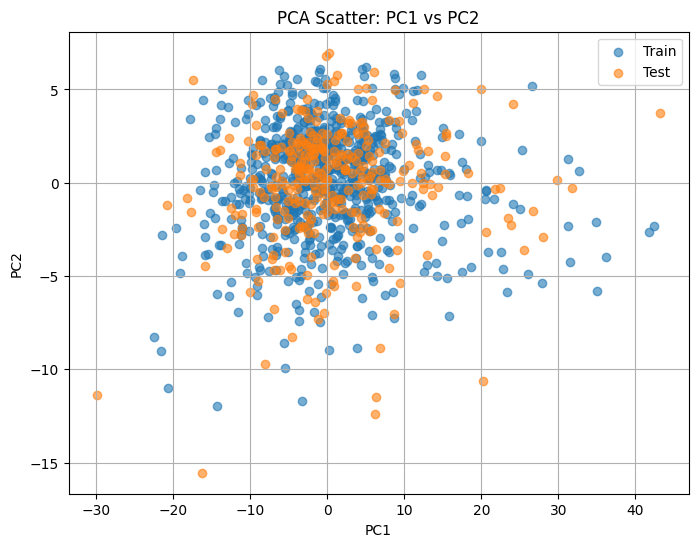

In [ ]:

plt.figure(figsize=(8, 6))

plt.scatter(X1_train_pca['PC1'], X1_train_pca['PC2'],
            alpha=0.6, label='Train')

plt.scatter(X1_test_pca['PC1'], X1_test_pca['PC2'],
            alpha=0.6, label='Test')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Scatter: PC1 vs PC2')
plt.legend()
plt.grid(True)

plt.show()


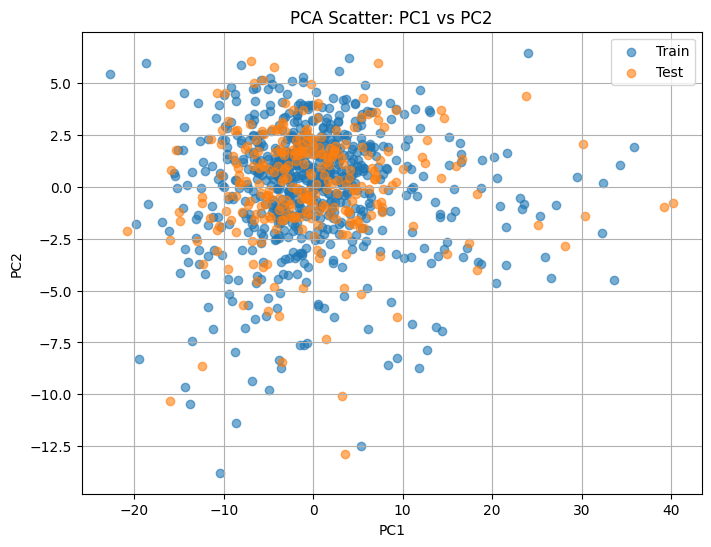

In [ ]:

plt.figure(figsize=(8, 6))

plt.scatter(X2_train_pca['PC1'], X2_train_pca['PC2'],
            alpha=0.6, label='Train')

plt.scatter(X2_test_pca['PC1'], X2_test_pca['PC2'],
            alpha=0.6, label='Test')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Scatter: PC1 vs PC2')
plt.legend()
plt.grid(True)

plt.show()

#### 10.2 Interpretazione dei risultati visivi

L'analisi dei grafici rivela le seguenti caratteristiche distribuzionali:

**Distribuzione nel Dataset 1**:
1. **Sovrapposizione significativa**: I punti del training set e del test set occupano regioni spaziali ampiamente sovrapposte, con particolare concentrazione nelle aree centrali dello spazio PC1-PC2.
2. **Copertura spaziale omogenea**: Entrambi i set presentano intervalli di variazione comparabili lungo gli assi PC1 e PC2, suggerendo una rappresentazione bilanciata delle componenti principali nei due gruppi.
3. **Continuità distributiva**: I campioni del test set si integrano organicamente con quelli del training set, senza evidenziare discontinuità o separazioni nette nella distribuzione spaziale.

**Distribuzione nel Dataset 2**:
1. **Omogeneità spaziale**: La distribuzione dei punti mostra una sostanziale uniformità tra training e test set, con sovrapposizione evidente in gran parte dello spazio bidimensionale.
2. **Consistenza nella copertura**: Gli estremi della distribuzione lungo PC1 e PC2 sono simili per entrambi i set, indicando che la suddivisione ha preservato l'ampiezza della variabilità originale.
3. **Integrazione distributiva**: I campioni del test set si collocano in modo coerente all'interno della distribuzione generale, senza formare cluster isolati o regioni spazialmente separate.

#### 10.4 Implicazioni metodologiche

1. **Validità della suddivisione**: La sovrapposizione osservata in entrambi i dataset conferma che la procedura GroupShuffleSplit ha prodotto divisioni rappresentative senza introdurre bias spaziali.

2. **Generalizzabilità dei modelli**: La similarità distribuzionale tra training e test set suggerisce che i modelli addestrati dovrebbero generalizzare efficacemente a nuovi dati.

3. **Efficacia della trasformazione PCA**: La distribuzione coerente dei punti indica che la riduzione dimensionale ha preservato la struttura essenziale dei dati originali.


### 11. Valutazione comparativa dei modelli predittivi

Per valutare rigorosamente le prestazioni predittive dei modelli e selezionare l'algoritmo ottimale per ciascun dataset, è stata implementata una strategia di cross-validation avanzata che rispetta la struttura gerarchica dei dati attraverso l'identità dei soggetti.

#### 11.1 Strategia di validazione con GroupKFold

La valutazione dei modelli è stata condotta utilizzando **GroupKFold cross-validation** con 5 fold, una metodologia che garantisce:

1. **Indipendenza statistica**: Tutte le osservazioni di uno stesso soggetto vengono mantenute nello stesso fold, prevenendo qualsiasi forma di data leakage
2. **Valutazione realistica**: Simula l'applicazione del modello a soggetti completamente nuovi, non visti durante l'addestramento
3. **Stime robuste**: Fornisce stime della performance più conservative e generalizzabili rispetto a tecniche di validazione standard

#### 11.2 Modelli confrontati

Sono stati selezionati due algoritmi rappresentativi di approcci diversi:

**11.2.1 Lasso Regression**
- **Tipo**: Modello lineare con regolarizzazione L1
- **Iperparametri**: `alpha=0.1` per bilanciare adattamento ai dati e riduzione della complessità
- **Vantaggi**:
  - Selezione automatica delle feature (coefficienti ridotti a zero)
  - Interpretabilità dei coefficienti
  - Resistenza alla multicollinearità

**11.2.2 Gradient Boosting Regressor**
- **Tipo**: Modello ensemble non lineare basato su alberi decisionali
- **Iperparametri ottimizzati**:
  - `n_estimators=50`: Compromesso tra capacità predittiva e costo computazionale
  - `learning_rate=0.2`: Tasso di apprendimento moderato per stabilità
  - `max_depth=3`: Limita la complessità degli alberi per prevenire overfitting
  - `min_samples_split=30`, `min_samples_leaf=15`: Parametri conservativi per alberi robusti
  - `subsample=0.5`: Stochastic gradient boosting per diversificazione
- **Vantaggi**:
  - Capacità di catturare relazioni non lineari e interazioni
  - Robustezza a outlier e variabili di scala diversa
  - Elevata capacità predittiva in problemi complessi

#### 11.3 Metriche di valutazione

Le performance sono state valutate utilizzando tre metriche complementari:

1. **R² (coefficiente di determinazione)**: Percentuale di varianza spiegata dalla variabile target
2. **MSE (Mean Squared Error)**: Errore quadratico medio, penalizza maggiormente errori grandi
3. **MAE (Mean Absolute Error)**: Errore assoluto medio, interpretabile nella scala originale della variabile target

#### 11.4 Implementazione metodologica

La valutazione è stata implementata attraverso due funzioni integrate:

1. **`cross_validation`**: Esegue cross-validation con GroupKFold e restituisce metriche dettagliate per fold
2. **`valuta_dataset`**: Confronta sistematicamente tutti i modelli su un dataset specifico e identifica il migliore

#### 11.5 Limiti e considerazioni

1. **Dipendenze temporali**: Se presenti, non sono state esplicitamente modellate

2. **Interpretabilità vs performance**: Esiste un trade-off intrinseco tra modelli lineari interpretabili (Lasso) e modelli non lineari potenzialmente più accurati (Gradient Boosting). In questo studio si è scelto di valutare entrambi gli approcci per comprendere quale offrisse il miglior compromesso nel contesto specifico.

3. **Complessità computazionale**: Gradient Boosting, sebbene prevedibilmente più performante, richiede maggiori risorse computazionali rispetto a modelli lineari.

In [ ]:

def cross_validation(X_train, y_train, groups_train, modello, nome_modello="Modello", cv_folds=5):
    """
    Esegue cross-validation con GroupKFold
    """

    print(f"\nCROSS-VALIDATION: {nome_modello}")


    gkf = GroupKFold(n_splits=cv_folds)

    scoring = {
        'r2': 'r2',
        'neg_mse': 'neg_mean_squared_error',
        'neg_mae': 'neg_mean_absolute_error'
    }

    cv_results = cross_validate(
        modello,
        X_train,
        y_train,
        groups=groups_train,
        cv=gkf,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )

    print(f"\nRisultati CV ({cv_folds}-fold con GroupKFold):")
    print(f"R² Test (media ± std): {cv_results['test_r2'].mean():.3f} ± {cv_results['test_r2'].std():.3f}")
    print(f"MSE Test (media): {abs(cv_results['test_neg_mse'].mean()):.3f}")
    print(f"MAE Test (media): {abs(cv_results['test_neg_mae'].mean()):.3f}")

    print(f"\nPerformance per fold (R² Test):")
    for i, test_score in enumerate(cv_results['test_r2']):
        print(f"  Fold {i+1}: {test_score:.3f}")

    return cv_results

def valuta_dataset(modelli_dict, X_train, y_train, groups_train, dataset_name):
    """
    Valuta tutti i modelli su un dataset specifico
    """

    print(f"\nCROSS-VALIDATION COMPARATIVA - {dataset_name}")

    print("Modelli testati: " + ", ".join(modelli_dict.keys()))

    risultati = {}

    for nome_modello, modello in modelli_dict.items():
        cv_res = cross_validation(
            X_train, y_train, groups_train,
            modello, nome_modello, cv_folds=5
        )
        risultati[nome_modello] = cv_res

    # Confronto finale

    print(f"\nCONFRONTO FINALE TRA MODELLI- {dataset_name}")


    print(f"\n{'Modello':<20} {'R² Test':<10} {'MSE Test':<10} {'MAE Test':<10}")


    for nome_modello in modelli_dict.keys():
        r2_test = risultati[nome_modello]['test_r2'].mean()
        mse_test = abs(risultati[nome_modello]['test_neg_mse'].mean())
        mae_test = abs(risultati[nome_modello]['test_neg_mae'].mean())
        print(f"{nome_modello:<20} {r2_test:<10.3f} {mse_test:<10.3f} {mae_test:<10.3f}")

    # Determina il modello migliore
    miglior_modello = max(modelli_dict.keys(), key=lambda x: risultati[x]['test_r2'].mean())
    miglior_r2 = risultati[miglior_modello]['test_r2'].mean()

    print(f"\nMIGLIOR MODELLO: {miglior_modello} (R² medio = {miglior_r2:.3f})")

    # Valutazione finale
    if miglior_r2 > 0.7:
        print(f"Eccellente! Il modello spiega oltre il 70% della varianza.")
    elif miglior_r2 > 0.5:
        print(f"Buono! Il modello spiega oltre il 50% della varianza.")
    elif miglior_r2 > 0.3:
        print(f"Accettabile! Il modello spiega oltre il 30% della varianza.")
    else:
        print(f"Modesto! Il modello spiega meno del 30% della varianza.")

    return risultati, miglior_modello, miglior_r2

# Definisci i modelli da confrontare
modelli = {
    'Lasso': Lasso(alpha=0.1),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=50,
        learning_rate=0.2,
        max_depth=3,
        min_samples_split=30,
        min_samples_leaf=15,
        subsample=0.5,
        random_state=42
    )
}


# VALUTAZIONE SU ENTRAMBI I DATASET

# Dataset 1
risultati_1, migliore_1, r2_1 = valuta_dataset(
    modelli, X1_train_final, y1_train, groups1_train, "DATASET 1"
)

# Dataset 2
risultati_2, migliore_2, r2_2 = valuta_dataset(
    modelli, X2_train_final, y2_train, groups2_train, "DATASET 2"
)

# CONFRONTO FINALE TRA DATASET
print("\nCONFRONTO FINALE TRA DATASET")


print(f"\n{'Modello':<20} {'Dataset 1 R²':<15} {'Dataset 2 R²':<15} {'Differenza':<15}")


for nome_modello in modelli.keys():
    r2_ds1 = risultati_1[nome_modello]['test_r2'].mean()
    r2_ds2 = risultati_2[nome_modello]['test_r2'].mean()
    diff = r2_ds2 - r2_ds1
    segno = "+" if diff > 0 else ""
    print(f"{nome_modello:<20} {r2_ds1:<15.3f} {r2_ds2:<15.3f} {segno}{diff:<15.3f}")

print(f"\nRIEPILOGO:")
print(f"  Dataset 1: {migliore_1} (R² = {r2_1:.3f})")
print(f"  Dataset 2: {migliore_2} (R² = {r2_2:.3f})")

if migliore_1 == migliore_2:
    print(f"CONSISTENZA: Lo stesso modello è migliore in entrambi i dataset")
else:
    print(f"DISCREPANZA: Modelli diversi sono migliori")


CROSS-VALIDATION COMPARATIVA - DATASET 1
Modelli testati: Lasso, GradientBoosting

CROSS-VALIDATION: Lasso

Risultati CV (5-fold con GroupKFold):
R² Test (media ± std): 0.644 ± 0.034
MSE Test (media): 0.087
MAE Test (media): 0.228

Performance per fold (R² Test):
  Fold 1: 0.684
  Fold 2: 0.585
  Fold 3: 0.653
  Fold 4: 0.666
  Fold 5: 0.632

CROSS-VALIDATION: GradientBoosting

Risultati CV (5-fold con GroupKFold):
R² Test (media ± std): 0.677 ± 0.066
MSE Test (media): 0.078
MAE Test (media): 0.212

Performance per fold (R² Test):
  Fold 1: 0.743
  Fold 2: 0.595
  Fold 3: 0.678
  Fold 4: 0.756
  Fold 5: 0.611

CONFRONTO FINALE TRA MODELLI- DATASET 1

Modello              R² Test    MSE Test   MAE Test  
Lasso                0.644      0.087      0.228     
GradientBoosting     0.677      0.078      0.212     

MIGLIOR MODELLO: GradientBoosting (R² medio = 0.677)
Buono! Il modello spiega oltre il 50% della varianza.

CROSS-VALIDATION COMPARATIVA - DATASET 2
Modelli testati: Lasso, Grad

### 11.6 Sintesi della valutazione comparativa in cross-validation

**11.6.1 Superiorità di Gradient Boosting nella CV**
- Miglioramento R² medio: +0.033 (5.1%) nel Dataset 1, +0.100 (16.0%) nel Dataset 2
- Riduzione MSE medio: -10.3% nel Dataset 1, -25.5% nel Dataset 2
- Riduzione MAE medio: -7.0% nel Dataset 1, -14.0% nel Dataset 2

**11.6.2 Stabilità delle performance nella CV**
- Gradient Boosting mostra maggiore stabilità nel Dataset 2 (deviazione std R² = 0.024 vs 0.064 di Lasso)
- Nel Dataset 1, Gradient Boosting presenta variabilità leggermente maggiore (deviazione std R² = 0.066) ma performance medie superiori

**11.6.3 Variabilità tra fold nella CV**
- Lasso mostra maggiore variabilità inter-fold, specialmente nel Dataset 2 (range R²: 0.524-0.690)
- Gradient Boosting mantiene performance più consistenti, particolarmente nel Dataset 2 (range R²: 0.697-0.756)

### 11.7 Conclusioni preliminari dalla cross-validation

Basandosi esclusivamente sui risultati della GroupKFold cross-validation, Gradient Boosting Regressor emerge come modello candidato ottimale per entrambi i dataset, mostrando performance superiori e maggiore stabilità. Il modello spiega il 67.7-72.5% della varianza nella variabile target `aveOralM` nei dati di validazione. Inoltre, la consistenza delle performance tra fold e tra dataset suggerisce una buona capacità di generalizzazione.

### 11.8 Implicazioni metodologiche per la fase successiva

I risultati della CV giustificano la prosecuzione della valutazione sul test set indipendente per verificare la capacità di generalizzazione. Entrambi i modelli procederanno alla fase di test set per:
   - Confermare la superiorità di Gradient Boosting su dati completamente indipendenti
   - Fornire una stima imparziale delle performance comparative

## 12. Validazione esterna sul test set

Dopo aver identificato i modelli candidati attraverso la cross-validation, è stata condotta una validazione finale sul test set per ottenere una stima imparziale della capacità di generalizzazione dei modelli a dati completamente nuovi.

### 12.1 Obiettivi della validazione esterna

La valutazione sul test set persegue due obiettivi metodologici fondamentali:

1. **Stima imparziale della generalizzazione**: Fornire una stima realistica delle prestazioni predittive su soggetti mai osservati durante l'addestramento
2. **Conferma della selezione modellistica**: Verificare che il modello identificato come ottimale in cross-validation mantenga la sua superiorità anche su dati indipendenti

### 12.2 Procedura di validazione

La funzione `valuta_su_test_set` implementa un protocollo rigoroso di validazione:

#### 12.2.1 Addestramento finale
- Ciascun modello viene addestrato sull'intero training set

#### 12.2.2 Predizione e valutazione
- Le predizioni vengono generate sul test set, mai utilizzato in alcuna fase precedente
- Vengono calcolate le stesse metriche della cross-validation (R², MSE, MAE) per garantire comparabilità

In [ ]:
def valuta_su_test_set(modelli_dict, X_train, y_train, X_test, y_test, dataset_name):
    """
    Addestra i modelli sul training set completo e valuta sul test set
    """

    print(f"\nVALUTAZIONE SUL TEST SET - {dataset_name}")

    risultati_test = {}
    miglior_r2 = -float('inf')
    miglior_modello_nome = None

    for nome_modello, modello in modelli_dict.items():
        # Addestra sul training completo
        modello.fit(X_train, y_train)

        # Predizioni
        y_pred = modello.predict(X_test)

        # Calcola metriche
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)

        # Stampa risultati
        print(f"\n{nome_modello}:")
        print(f"  R² Test:  {r2:.4f}")
        print(f"  MSE Test: {mse:.4f}")
        print(f"  MAE Test: {mae:.4f}")

        # Salva per il confronto
        risultati_test[nome_modello] = {
            'R2': r2,
            'MSE': mse,
            'MAE': mae,
            'modello': modello
        }

        # Trova il migliore
        if r2 > miglior_r2:
            miglior_r2 = r2
            miglior_modello_nome = nome_modello

    # Confronto finale

    print(f"\nCONFRONTO FINALE TRA MODELLI- {dataset_name}")


    print(f"\n{'Modello':<20} {'R² Test':<10} {'MSE Test':<10} {'MAE Test':<10}")


    for nome_modello in modelli_dict.keys():
        r2 = risultati_test[nome_modello]['R2']
        mse = risultati_test[nome_modello]['MSE']
        mae = risultati_test[nome_modello]['MAE']
        print(f"{nome_modello:<20} {r2:<10.4f} {mse:<10.4f} {mae:<10.4f}")

    print(f"\nMIGLIOR MODELLO SUL TEST SET: {miglior_modello_nome}")
    print(f"   R²: {miglior_r2:.4f}")

    return risultati_test, miglior_modello_nome

# Dataset 1
risultati_test_1, migliore_test_1 = valuta_su_test_set(
    modelli, X1_train_final, y1_train, X1_test_final, y1_test, "DATASET 1"
)

# Dataset 2
risultati_test_2, migliore_test_2 = valuta_su_test_set(
    modelli, X2_train_final, y2_train, X2_test_final, y2_test, "DATASET 2"
)

# Confronto tra i due dataset
print("\nCONFRONTO FINALE TRA DATASET (TEST SET)")

print(f"\nDataset 1: {migliore_test_1} (R² = {risultati_test_1[migliore_test_1]['R2']:.4f})")
print(f"Dataset 2: {migliore_test_2} (R² = {risultati_test_2[migliore_test_2]['R2']:.4f})")

if migliore_test_1 == migliore_test_2:
    print(f"\nCONSISTENZA: Lo stesso modello è il migliore in entrambi i dataset")
else:
    print(f"\nDISCREPANZA: Modelli diversi sono migliori nei due dataset")


VALUTAZIONE SUL TEST SET - DATASET 1

Lasso:
  R² Test:  0.6689
  MSE Test: 0.0916
  MAE Test: 0.2298

GradientBoosting:
  R² Test:  0.7525
  MSE Test: 0.0685
  MAE Test: 0.1972

CONFRONTO FINALE TRA MODELLI- DATASET 1

Modello              R² Test    MSE Test   MAE Test  
Lasso                0.6689     0.0916     0.2298    
GradientBoosting     0.7525     0.0685     0.1972    

MIGLIOR MODELLO SUL TEST SET: GradientBoosting
   R²: 0.7525

VALUTAZIONE SUL TEST SET - DATASET 2

Lasso:
  R² Test:  0.6457
  MSE Test: 0.0909
  MAE Test: 0.2345

GradientBoosting:
  R² Test:  0.7411
  MSE Test: 0.0664
  MAE Test: 0.1934

CONFRONTO FINALE TRA MODELLI- DATASET 2

Modello              R² Test    MSE Test   MAE Test  
Lasso                0.6457     0.0909     0.2345    
GradientBoosting     0.7411     0.0664     0.1934    

MIGLIOR MODELLO SUL TEST SET: GradientBoosting
   R²: 0.7411

CONFRONTO FINALE TRA DATASET (TEST SET)

Dataset 1: GradientBoosting (R² = 0.7525)
Dataset 2: GradientBoostin

### 12.3 Analisi comparativa delle performance

#### 12.3.1 Superiorità confermata di Gradient Boosting
La validazione esterna conferma inequivocabilmente i risultati della cross-validation:

**Dataset 1**:
- Miglioramento R²: +12.5% (0.7525 vs 0.6689)
- Riduzione MSE: -25.2% (0.0685 vs 0.0916)
- Riduzione MAE: -14.2% (0.1972 vs 0.2298)

**Dataset 2**:
- Miglioramento R²: +14.8% (0.7411 vs 0.6457)
- Riduzione MSE: -27.0% (0.0664 vs 0.0909)
- Riduzione MAE: -17.5% (0.1934 vs 0.2345)

#### 12.3.2 Consistenza cross-dataset
- **Stesso modello ottimale**: Gradient Boosting si conferma il migliore in entrambi i dataset
- **Performance comparabili**: R² di 0.7525 (Dataset 1) e 0.7411 (Dataset 2) indicano capacità predittive eccellenti e robuste
- **Differenza minima**: Lo scarto di soli 0.0114 (1.5%) tra le performance dei due dataset suggerisce alta stabilità del modello

### 12.4 Implicazioni  
### 12.4.1 Metodologiche
La superiorità di Gradient Boosting è dimostrata sia internamente (CV) che esternamente (test set). La coerenza tra diverse strategie di validazione supporta l'affidabilità dei risultati. Infine, le performance eccellenti su dati completamente nuovi indicano alta capacità di generalizzazione.

#### 12.4.2 Cliniche

- **Alta capacità esplicativa**: R² > 0.74 indica che il modello cattura la maggior parte della variabilità nel parametro orale medio
- **Errori clinicamente accettabili**: MAE di circa 0.19-0.20 unità fornisce un'indicazione dell'accuratezza attesa nelle applicazioni cliniche

### 12.5 Limiti della validazione esterna

1. **Dimensione del test set**: Sebbene rappresentativo (30% dei dati totali), un test set più ampio potrebbe fornire stime ancora più stabili
2. **Stabilità temporale**: La validazione non considera esplicitamente possibili variazioni temporali nelle caratteristiche dei soggetti